# COGS 108 - Final Project 

# Overview

In this project, I analyzed the relationship between parkland and poverty rates as well as parkland and unemployment rates. My goal was to figure out if there were any patterns between these variables so that I could reasonably predict the economic welfare of an area based on the number of parks there are. I concluded that there are no relationships between these variables.

# Name & GitHub

- Name: Edbert Dai
- GitHub Username: edbertdai

# Research Question

Does the presence of more parkland in an area reflect the economic welfare of the people living in that area? Specifically, do the number of parks affect the poverty and unemployment rates?

## Background and Prior Work

Parks are an important fixture of city planning and their importance to the local economy is often touted as being one of the main reasons to build them. Parks agencies across the country have created more than 1.1 million jobs and more than $166 billion in economic activity.<sup>[1]</sup> The presence of parks also increases property values which is a result of the demand generated from people preferring properties in close proximity to parks.<sup>[1][2]</sup> Places that have parks tend to attract and retain affluent people as well as "knowledge workers" which are people who have jobs that do not pertain to physical labor.<sup>[3]</sup>


Unfortunately, despite this, people still face unemployment and poverty is a reality. The percentage of San Diego County residents in poverty is around 13\% for individuals and 9\% for families while the unemployment rate is around 7\%.<sup>[4]</sup> The poverty rate around the county ranges widely from as low as 5\% in Poway to as high as 32\% in El Cajon. A study conducted in a Southern California city found that parks in higher poverty areas were smaller than those in lower-poverty areas.<sup>[5]</sup> Parks reportedly also reduce employment as employers factor in the quality of life when choosing areas to do business in.<sup>[2]</sup>

My project will be looking at how parks affect the economic welfare of the immediate population. The factors I am looking into are the poverty and unemployment rates. I intend to link the welfare of people living in census tracts to the amount of parkland in the zip code where the census tract is located.

References (include links):
- 1) https://www.nrpa.org/siteassets/research/economic-impact-study-summary-2020.pdf
- 2) http://recreation1.townofmanchester.org/index.cfm/benefits-of-recreation/
- 3) https://conservationtools.org/guides/98-economic-benefits-of-parks
- 4) https://sandag.org/uploads/publicationid/publicationid_1813_17012.pdf
- 5) https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3646794/

# Hypothesis


The amount of parkland in an area will be representative of the welfare of the people living there. If there are a lot of parks, the poverty and unemployment rates will be low. Conversely, fewer or no parks will increase poverty and unemployment.

# Dataset(s)

- Dataset Name: CalEnviroScreen 2.0
- Link to the dataset: https://data.ca.gov/dataset/calenviroscreen-2-0
- Number of observations: 8035

This dataset is provided by the Office of Environmental Health Hazard Assessment (OEHHA). It contains environmental pollution and socioeconomic data for census tracts in California in 2010. In addition, it has the coordinates, county name, zip codes for each census tract.

- Dataset Name: Park Locations
- Link to the dataset: https://data.sandiego.gov/datasets/park-locations/
- Number of observations: 2769

This dataset is provided by the City of San Diego. It lists all the names of parks in San Diego County, their location boundries, surface areas by acre, type, and owner.

- Dataset Name: Zip Codes
- Link to the dataset: https://data.sandiegocounty.gov/Maps-and-Geographical-Resources/Zip-Codes/vsuf-uefy
- Number of observations: 122

This dataset is provided by San Diego County. It provides the geometry of the boundries for each zip code in San Diego County.

I plan to merge the Park Locations and Zip Codes datasets by intersecting their geometries to determine which zip code each park is in. I am also going to use Park Locations to calculate the acerage of parkland in each zip code and then insert that data into CalEnviroScreen 2.0 for each census tract based on the zip code.

# Setup

In [1]:
# Import libraries
import geopandas as gpd
import pandas as pd
import patsy
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Read datasets
enviro_df = pd.read_csv('../data/calenviroscreen-final-report.csv')
parks_df = gpd.read_file('../data/parks_datasd.geojson')
zip_df = gpd.read_file('../data/Zip Codes.geojson')

# Data Cleaning

First, I needed to narrow down the CalEnviroScreen data to only those about San Diego. I needed to get the zip code for each census tract, so I extracted the zip code from the location column and placed that into a new column. I then dropped the rows from both the CalEnviroScreen and parks data that I won't use for the analysis. Finally, I renamed the columns for clarity and consistency.

In [2]:
# Filter environmental data to those from San Diego
enviro_df = enviro_df[enviro_df['California County'] == 'San Diego']

# Extract zip code from location column and place into new column
enviro_df['zip'] = enviro_df['Location 1'].str.extract(r'(\d{5}\-?\d{0,4})')

# Drop unnecessary columns
enviro_df = enviro_df[['Census Tract', 'Total Population', 'Poverty', 'Unemployment', 'zip']]
parks_df = parks_df[['name', 'gis_acres', 'geometry']]
zip_df = zip_df[['zip', 'geometry']]

# Rename columns
enviro_df = enviro_df.rename(columns={'Census Tract': 'census_tract', 'Total Population': 'population', 'Poverty': 'poverty_percent', 'Unemployment': 'unemployment_percent'})
parks_df = parks_df.rename(columns={'gis_acres': 'acres'})

Here, I did a geopandas spatial join between the parks and zip code data to extract the zip codes that each park is in. This involved finding the intersection of the geometries of the two datasets.

In [3]:
# Spatial join between parks and zip code datasets
parks_df = gpd.sjoin(parks_df, zip_df, how='left')

# Drop index_right column
parks_df = parks_df.drop(columns=['index_right'])

Before proceeding further, I wanted to check if any parks were not assigned to a zip code. I found one park that didn't have a zip code and also found that the geometry of the park is not within a zip code. I then check if that park was assigned a zip code using another portion of the geometry and find that it was. I can then safely drop the nan values.

In [4]:
# Check for parks not assigned a zip code
parks_df[parks_df['zip'].isna()]

,name,acres,geometry,zip
74,Leucadia SB,4.247821,"POLYGON ((-117.30451 33.06264, -117.30452 33.0...",NaN


In [5]:
# Check if park was assigned a zip code under different geometry
parks_df[parks_df['name'] == 'Leucadia SB']

,name,acres,geometry,zip
74,Leucadia SB,4.247821,"POLYGON ((-117.30451 33.06264, -117.30452 33.0...",NaN
391,Leucadia SB,11.696144,"POLYGON ((-117.30451 33.06264, -117.30428 33.0...",92024


In [6]:
# Drop nan values
parks_df = parks_df.dropna(subset=['zip'])

parks_df

,name,acres,geometry,zip
0,South Carlsbad SB,115.895878,"MULTIPOLYGON (((-117.31431 33.09015, -117.3142...",92008
0,South Carlsbad SB,115.895878,"MULTIPOLYGON (((-117.31431 33.09015, -117.3142...",92011
0,South Carlsbad SB,115.895878,"MULTIPOLYGON (((-117.31431 33.09015, -117.3142...",92024
1,Torrey Pines SB,67.294309,"POLYGON ((-117.26147 32.93883, -117.26181 32.9...",92014
1,Torrey Pines SB,67.294309,"POLYGON ((-117.26147 32.93883, -117.26181 32.9...",92037
...,...,...,...,...
2764,San Luis Rey River Park,712.262117,"MULTIPOLYGON (((-117.17632 33.31105, -117.1766...",92003
2765,Horse Creek Ridge Sports Park,8.398529,"POLYGON ((-117.15413 33.35376, -117.15413 33.3...",92028
2766,,2.510408,"POLYGON ((-117.13226 33.10238, -117.13225 33.1...",92029
2767,Harmony Grove Community Park,3.575260,"POLYGON ((-117.13391 33.09869, -117.13376 33.0...",92029


I needed to check why some census tracts don't have data for poverty percentages. Using the census tract maps on the OEHHA website, I found that these census tracts correspond to military installations. As residents of military installations typically have their housing paid for and a sufficient salary, I will assume that the poverty percentage is extremely low to none. I drop these rows as they may skew the analysis.

In [7]:
# Check for nan values in poverty_percent column
enviro_df[enviro_df['poverty_percent'].isna()]

,census_tract,population,poverty_percent,unemployment_percent,zip
5568,6073003800,6530,NaN,NaN,92136
6856,6073010900,1750,NaN,3.53,92118
7512,6073009901,626,NaN,NaN,92106
7565,6073013417,2087,NaN,10.86,91913
7694,6073011300,6520,NaN,NaN,92135
7829,6073008336,2332,NaN,9.94,92129
8020,6073005500,198,NaN,NaN,92134
8021,6073006200,144,NaN,NaN,92101
8022,6073006300,3435,NaN,NaN,92140
8023,6073009902,2,NaN,NaN,92118


In [8]:
# Drop nan values
enviro_df = enviro_df.dropna(subset=['poverty_percent'])

enviro_df

,census_tract,population,poverty_percent,unemployment_percent,zip
165,6073005000,2227,74.855946,NaN,92113
299,6073003601,3250,76.636392,17.84,92113
370,6073004900,5028,70.019802,13.77,92113
466,6073003902,4927,76.470588,19.39,92113
805,6073003901,4241,79.242069,28.52,92113
...,...,...,...,...,...
7904,6073017053,3364,5.335027,4.95,92064
7908,6073008102,3395,5.771725,4.82,92037
7943,6073007907,3048,35.107914,2.58,92109
7951,6073007301,4948,30.536181,7.50,92107


There are only two observations that have nan values for unemployment percent. I checked the OEHHA maps for these census tracts and I couldn't come to a conclusion why this is the case. As there are only two observations of this sort, I will drop them and not include these data points in the analysis. I also made sure to take note of this.

In [9]:
enviro_df[enviro_df['unemployment_percent'].isna()]

,census_tract,population,poverty_percent,unemployment_percent,zip
165,6073005000,2227,74.855946,NaN,92113
4595,6073006600,1920,47.180548,NaN,92110


In [10]:
enviro_df = enviro_df.dropna(subset=['unemployment_percent'])

enviro_df

,census_tract,population,poverty_percent,unemployment_percent,zip
299,6073003601,3250,76.636392,17.84,92113
370,6073004900,5028,70.019802,13.77,92113
466,6073003902,4927,76.470588,19.39,92113
805,6073003901,4241,79.242069,28.52,92113
807,6073005100,7140,69.253137,25.23,92113
...,...,...,...,...,...
7904,6073017053,3364,5.335027,4.95,92064
7908,6073008102,3395,5.771725,4.82,92037
7943,6073007907,3048,35.107914,2.58,92109
7951,6073007301,4948,30.536181,7.50,92107


I wanted to compute the total park area for each census tract in the environmental dataset. I took the park data, grouped it by zip, and then summed the acres. I created a function that replaces a zip code with the summed park acreage and applied that function to the environmental dataset.

In [11]:
# Compute the total park acreage for a zip code
acres_df = parks_df.groupby(by=['zip'], as_index=False)['acres'].sum()

# Function to apply the total park acreage for a zip code
def apply_park_acres(zip):
    try:
        return acres_df[acres_df['zip'] == zip]['acres'].item()
    except:
        return 0

# Copy over zip codes to new column so they can be transformed
enviro_df = enviro_df.copy()
enviro_df['park_acres'] = enviro_df['zip']

# Apply compute_park_acres
enviro_df['park_acres'] = enviro_df['park_acres'].apply(apply_park_acres)

enviro_df

,census_tract,population,poverty_percent,unemployment_percent,zip,park_acres
299,6073003601,3250,76.636392,17.84,92113,108.966269
370,6073004900,5028,70.019802,13.77,92113,108.966269
466,6073003902,4927,76.470588,19.39,92113,108.966269
805,6073003901,4241,79.242069,28.52,92113,108.966269
807,6073005100,7140,69.253137,25.23,92113,108.966269
...,...,...,...,...,...,...
7904,6073017053,3364,5.335027,4.95,92064,3905.410576
7908,6073008102,3395,5.771725,4.82,92037,2821.156510
7943,6073007907,3048,35.107914,2.58,92109,4281.131053
7951,6073007301,4948,30.536181,7.50,92107,4295.509503


Here, I wanted to make sure that any zip codes with zero park acres truly have no city parks. There is one observation with no parks so I checked Google Maps to verify that there are no parks in that zip code. It turned out that this is an especially rural area with no parks at all.

In [12]:
# Manually check zeroed data for validity
enviro_df[enviro_df['park_acres'] == 0]

,census_tract,population,poverty_percent,unemployment_percent,zip,park_acres
5367,6073019101,7458,27.907992,7.81,92061,0.0


# Data Analysis & Results

I started by plotting a scatter matrix of the variables I am observing to get an overall picture of how the variables interact. By doing this, I saw that there are major outliers in the park acres data which makes it hard to scout for correlation.

array([[<AxesSubplot:xlabel='poverty_percent', ylabel='poverty_percent'>,
        <AxesSubplot:xlabel='unemployment_percent', ylabel='poverty_percent'>,
        <AxesSubplot:xlabel='park_acres', ylabel='poverty_percent'>],
       [<AxesSubplot:xlabel='poverty_percent', ylabel='unemployment_percent'>,
        <AxesSubplot:xlabel='unemployment_percent', ylabel='unemployment_percent'>,
        <AxesSubplot:xlabel='park_acres', ylabel='unemployment_percent'>],
       [<AxesSubplot:xlabel='poverty_percent', ylabel='park_acres'>,
        <AxesSubplot:xlabel='unemployment_percent', ylabel='park_acres'>,
        <AxesSubplot:xlabel='park_acres', ylabel='park_acres'>]],
      dtype=object)

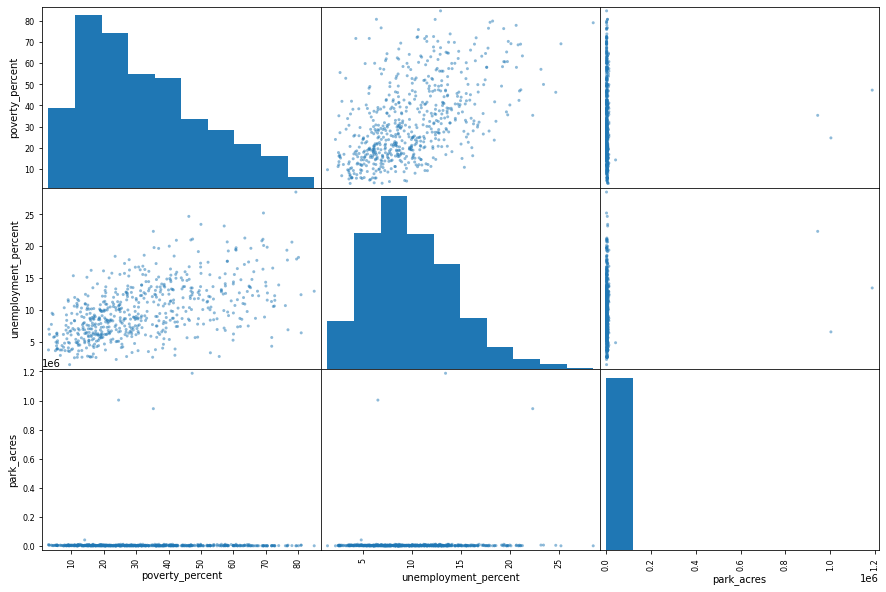

In [13]:
pd.plotting.scatter_matrix(enviro_df[['poverty_percent', 'unemployment_percent', 'park_acres']], figsize=(15, 10))

Here, I took a look at the data for the outliers. Using the OEHHA census tract website and Google Maps, I confirmed that these data points are valid. I will leave them in as the data does not seem to have inaccuracies.

In [14]:
enviro_df[enviro_df['park_acres'] > 40000]

,census_tract,population,poverty_percent,unemployment_percent,zip,park_acres
4098,6073021000,4440,47.287341,13.46,92004,1.187647e+06
4484,6073020903,3192,35.320687,22.35,92086,9.439348e+05
5776,6073020904,3075,24.616329,6.56,92036,1.003049e+06
7130,6073020902,2122,14.163090,4.86,91916,4.061412e+04


To get a sense of how poverty and unemployment rates are distributed and to ensure the data is correct, I plotted them to visualize their distributions.

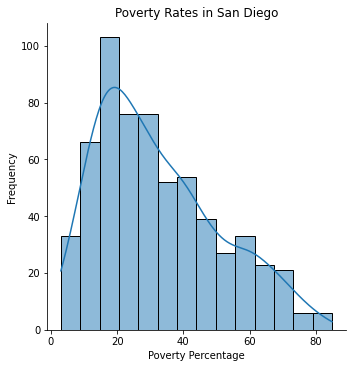

In [15]:
sns.displot(enviro_df['poverty_percent'], kde=True)
plt.title('Poverty Rates in San Diego')
plt.xlabel('Poverty Percentage')
ax = plt.ylabel('Frequency')

It appears that poverty percentage is not normally distributed. It seems that it is somewhat positively skewed which is expected as the distribution appears in line with the county poverty rate.

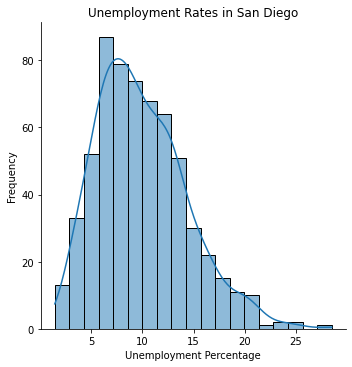

In [16]:
sns.displot(enviro_df['unemployment_percent'], kde=True)
plt.title('Unemployment Rates in San Diego')
plt.xlabel('Unemployment Percentage')
ax = plt.ylabel('Frequency')

It appears that unemployment percentage is not normally distributed. It seems that it is somewhat positively skewed which is expected as the distribution appears in line with the county unemployment rate.

To visualize the relationship between park acreage and the other variables, I created a new dataframe that omits the outliers.

In [17]:
# Create new dataframe for visualizations
vis_df = enviro_df[enviro_df['park_acres'] < 40000]

I will now use the new dataframe to plot park acreage versus poverty percentage.

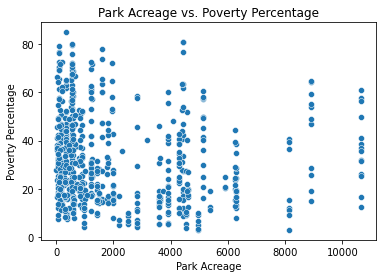

In [18]:
sns.scatterplot(x=vis_df['park_acres'], y=vis_df['poverty_percent'], data=vis_df)
plt.title('Park Acreage vs. Poverty Percentage')
plt.xlabel('Park Acreage')
ax = plt.ylabel('Poverty Percentage')

What I gathered from looking at the plot above is that there doesn't seem to be any particular relationship between park acreage and poverty percentage. As park acreage increases, the range of poverty rate does not seem to decrease by a substantial margin.

Below, I will plot park acreage versus unemployment percentage.

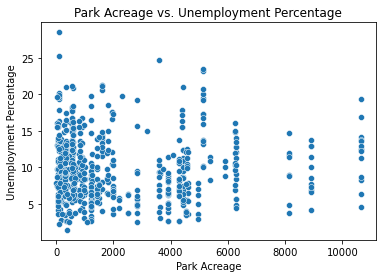

In [19]:
sns.scatterplot(x=vis_df['park_acres'], y=vis_df['unemployment_percent'], data=vis_df)
plt.title('Park Acreage vs. Unemployment Percentage')
plt.xlabel('Park Acreage')
ax = plt.ylabel('Unemployment Percentage')

The plot above tells me that there isn't an obvious relationship between park acreage and unemployment percentage. As park acreage increases, the range of the unemployment rate does not seem to drastically increase or decrease. However, the two plots above are very similar which tells me that poverty and unemployment seem highly correlated.

I will now check the correlation between the variables to reinforce my findings above.

In [20]:
enviro_df.corr()

,census_tract,population,poverty_percent,unemployment_percent,park_acres
census_tract,1.000000,0.138588,-0.189785,-0.082698,0.103369
population,0.138588,1.000000,-0.034897,0.000119,-0.035710
poverty_percent,-0.189785,-0.034897,1.000000,0.533545,0.010775
unemployment_percent,-0.082698,0.000119,0.533545,1.000000,0.061891
park_acres,0.103369,-0.035710,0.010775,0.061891,1.000000


From the correlation matrix above, I can conclude that park acreage in an area is not very correlated with either poverty percentage or unemployment percentage. Poverty percentage and unemployment percentage correlate which is typical so I know the data is not incorrectly entered.

I wanted to ensure that I am not missing anything, so below I will create a linear regression model for each pair of variables used in the scatterplots.

In [21]:
# Perform linear regression on poverty_percent and park_acres
outcome_1, predictors_1 = patsy.dmatrices('poverty_percent ~ park_acres', enviro_df)
mod_1 = sm.OLS(outcome_1, predictors_1)
res_1 = mod_1.fit()
print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:        poverty_percent   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                   0.07117
Date:                Wed, 16 Dec 2020   Prob (F-statistic):              0.790
Time:                        01:41:00   Log-Likelihood:                -2662.2
No. Observations:                 615   AIC:                             5328.
Df Residuals:                     613   BIC:                             5337.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     32.2780      0.745     43.321      0.0

Both the R-squared value and p-value are high so my model suggests that there is likely no relationship between park acreage and poverty percentage.

In [22]:
# Perform linear regression on unemployment_percent and park_acres
outcome_2, predictors_2 = patsy.dmatrices('unemployment_percent ~ park_acres', enviro_df)
mod_2 = sm.OLS(outcome_2, predictors_2)
res_2 = mod_2.fit()
print(res_2.summary())

                             OLS Regression Results                             
Dep. Variable:     unemployment_percent   R-squared:                       0.004
Model:                              OLS   Adj. R-squared:                  0.002
Method:                   Least Squares   F-statistic:                     2.357
Date:                  Wed, 16 Dec 2020   Prob (F-statistic):              0.125
Time:                          01:41:00   Log-Likelihood:                -1781.6
No. Observations:                   615   AIC:                             3567.
Df Residuals:                       613   BIC:                             3576.
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.9018      0.178

Both the R-squared value and p-value are high so this model tells us that a relationship between park acreage and unemployment percentage is highly unlikely.

I can conclude that there is no relationship between any of the variables in this analysis.

# Ethics & Privacy

The datasets were provided by OEHHA, the City of San Diego, and San Diego County for public use, so I have permission to use them for my analysis. The park data is licensed under the PDDL license which declares it as public domain. Since the data is public-facing without barriers, the agencies handling the data have presumably removed any personally identifiable information. For my analysis, I did not require or use any private information. 

As for data bias, the OEHHA data may be biased as it categorizes information based on census tracts which may or may not be arbitrarily decided on. The fact that some areas were excluded and had missing data may also be a source of bias in the dataset. I acknowledge that my analysis will be affected by this potential bias and I look into why these data are missing and how I will incorporate this into my analysis. The ethics of my project have to be discussed as I am generalizing the welfare of populations based on these boundaries. Some groups of people may be unfairly judged based on the fact that they are living within certain census tracts. Since my analysis does not use any personal or race information, there it is hard to discriminate or draw any conclusions to certain demographics based on my analysis alone.

# Conclusion & Discussion

In this project, I set out to find the relationship between parkland and poverty rates as well as parkland and unemployment rates to judge how parks affect the economic welfare of populations. After conducting my analysis, I can conclude that in San Diego there is no relationship between parks and poverty as well as parks and unemployment rates. This disproved my hypothesis which was that there would be some relationship between these variables.

I had to relate two datasets with one containing the socioeconomic data by census tract and the other containing the geometries of each park. I started by assigning a zip code to each park and computing the acreage of parkland in each zip code. I then assigned each census tract a zip code and used zip codes to assign the amount of parkland each census tract has access to. A problem I ran into while cleaning was that there were missing values for poverty rates and unemployment rates for certain census tracts. I ultimately decided to not include these in my analysis as most could be explained as being military installations and the remaining few were unlikely to skew the analysis. I proceeded to explore the data by plotting the variables on graphs to visualize any correlations they may have. This led to me not finding any correlations so I confirmed this by running a linear regression which also turned up the same results.

This project brought insight into how parks affect and reflect the welfare of the people they serve. It can help lead the discussion about how to better improve the park system without unnecessarily building more parks. Hopefully, my analysis will better allocate city park resources to other sectors that will improve the quality of city parks and in turn positively affect the living standards of city residents. There are some limitations of my project which may have affected my conclusion. The first is that I could not include every census tract due to missing data. Most of these census tracts justified to not be included in the analysis but some I could not explain although these were few. Another limitation is that I assumed that people in census tracts are in the same vicinity of parks in the entire zip code they reside in rather than just the census tract. This may have affected the results as it increased the area that would be considered accessible. Another consideration is that the data is slightly outdated as the park data is from 2020 but the poverty and unemployment rate data is from 2010. I had to operate under the assumption that no new parks were built.